
# Twitter EDA Scaffold (May 2010)

Memory-safe, line-streamed EDA for `2010-05-uncompressed` (NDJSON). Sections:
1. Dataset overview (counts, files)
2. Geo completeness (place/bounding_box/coordinates)
3. Temporal patterns (daily counts)
4. Country distribution
5. Content signals (hashtags, mentions, source, retweet_count)

Notes:
- Operates on NDJSON; avoids `user.lang` per requirement.
- Uses streaming to prevent OOM; adjust `LIMIT_LINES` to sample if needed.


In [1]:

import json
from pathlib import Path
from collections import Counter, defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

DATA_DIR = Path('2010-05-uncompressed')
FILES = sorted(DATA_DIR.glob('*.json'))
print(f"Found {len(FILES)} files")

# Set to an integer to sample N lines total; None to scan all.
LIMIT_LINES = None


Found 31 files


## 1) Dataset overview (line counts per day)

In [2]:

def iter_tweets(files, limit=None):
    '''Yield tweet dicts from NDJSON files; optional global limit.'''
    seen = 0
    for fp in files:
        with fp.open() as f:
            for line in f:
                if limit is not None and seen >= limit:
                    return
                seen += 1
                yield json.loads(line)

def iter_entities(tweet):
    '''Return hashtags and mentions from entities (lowercased).'''
    ents = tweet.get('entities') or {}
    hashtags = [h.get('text','').lower() for h in ents.get('hashtags', []) if h.get('text')]
    mentions = [m.get('screen_name','').lower() for m in ents.get('user_mentions', []) if m.get('screen_name')]
    return hashtags, mentions


In [3]:

per_file_counts = []
for fp in FILES:
    count = 0
    with fp.open() as f:
        for _ in f:
            count += 1
            if LIMIT_LINES and count >= LIMIT_LINES:
                break
    per_file_counts.append((fp.name.replace('.json',''), count))

counts_df = pd.DataFrame(per_file_counts, columns=['day','tweet_count']).sort_values('day')
counts_df


,day,tweet_count
0,2010-05-01,0
1,2010-05-02,0
2,2010-05-03,0
3,2010-05-04,0
4,2010-05-05,0
5,2010-05-06,0
6,2010-05-07,1009
7,2010-05-08,12864
8,2010-05-09,11970
9,2010-05-10,11394


## 2) Geo completeness (place, bounding_box, coordinates)

In [4]:

geo_counts = Counter()

for tw in iter_tweets(FILES, limit=LIMIT_LINES):
    place = tw.get('place')
    coords = tw.get('coordinates')
    geo = tw.get('geo')

    geo_counts['total'] += 1
    if place is not None:
        geo_counts['place'] += 1
        if place.get('country'):
            geo_counts['place_country'] += 1
        if place.get('country_code'):
            geo_counts['place_country_code'] += 1
        bb = place.get('bounding_box')
        if bb and bb.get('coordinates'):
            geo_counts['bounding_box'] += 1
    if coords and coords.get('coordinates'):
        geo_counts['coordinates_point'] += 1
    if geo and geo.get('coordinates'):
        geo_counts['geo_point'] += 1
    if (place is None) and coords and coords.get('coordinates'):
        geo_counts['no_place_but_coords'] += 1

geo_counts


Counter({'total': 217636,
         'place': 97626,
         'place_country': 97626,
         'place_country_code': 97626,
         'bounding_box': 88642,
         'coordinates_point': 217636,
         'geo_point': 217636,
         'no_place_but_coords': 120010})

Percentage view (if full scan)

In [5]:

if geo_counts['total']:
    pct = {k: geo_counts.get(k,0)/geo_counts['total']*100 for k in geo_counts if k != 'total'}
    print(pct)


{'place': 44.85746843353122, 'place_country': 44.85746843353122, 'place_country_code': 44.85746843353122, 'bounding_box': 40.72947490304913, 'coordinates_point': 100.0, 'geo_point': 100.0, 'no_place_but_coords': 55.142531566468776}


## 3) Temporal patterns (daily line plot)

Text(0, 0.5, 'Tweets')

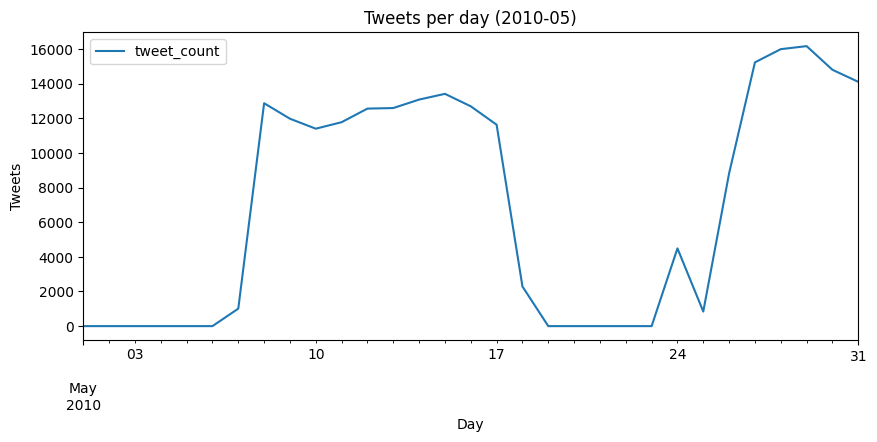

In [6]:

counts_df['day'] = pd.to_datetime(counts_df['day'], format='%Y-%m-%d')
counts_df = counts_df.sort_values('day')
ax = counts_df.plot(x='day', y='tweet_count', kind='line', figsize=(10,4), title='Tweets per day (2010-05)')
ax.set_xlabel('Day')
ax.set_ylabel('Tweets')


## 3b) Weekday distribution

missing created_at: 0


Text(0, 0.5, 'Tweets')

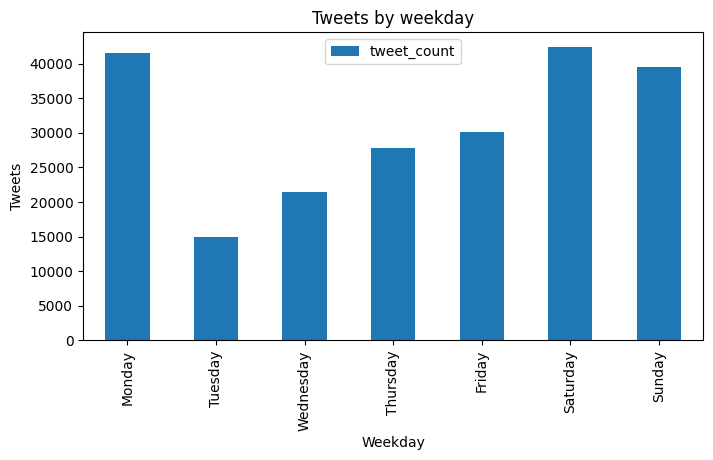

In [7]:
import email.utils

weekday_counts = Counter()
missing_created = 0

for tw in iter_tweets(FILES, limit=LIMIT_LINES):
    created_at = tw.get('created_at')
    if not created_at:
        missing_created += 1
        continue
    dt = email.utils.parsedate_to_datetime(created_at)
    weekday_counts[dt.strftime('%A')] += 1

print("missing created_at:", missing_created)

weekday_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
weekday_df = pd.DataFrame([(w, weekday_counts.get(w, 0)) for w in weekday_order],
                          columns=['weekday', 'tweet_count'])
ax = weekday_df.plot(x='weekday', y='tweet_count', kind='bar', figsize=(8, 4),
                     title='Tweets by weekday')
ax.set_xlabel('Weekday')
ax.set_ylabel('Tweets')


In [8]:
import email.utils
from collections import Counter
import pandas as pd

date_counts = Counter()
missing_created = 0

for tw in iter_tweets(FILES, limit=LIMIT_LINES):
    created_at = tw.get('created_at')
    if not created_at:
        missing_created += 1
        continue
    dt = email.utils.parsedate_to_datetime(created_at).date()
    date_counts[dt] += 1

print("missing created_at:", missing_created)

daily_df = pd.DataFrame(
    sorted(date_counts.items()),
    columns=['date', 'tweet_count']
)
daily_df['weekday'] = pd.to_datetime(daily_df['date']).dt.day_name()

daily_df  # shows every date with weekday + count


missing created_at: 0


,date,tweet_count,weekday
0,2010-05-07,1009,Friday
1,2010-05-08,12864,Saturday
2,2010-05-09,11970,Sunday
3,2010-05-10,11394,Monday
4,2010-05-11,11770,Tuesday
5,2010-05-12,12554,Wednesday
6,2010-05-13,12586,Thursday
7,2010-05-14,13075,Friday
8,2010-05-15,13406,Saturday
9,2010-05-16,12686,Sunday


[Text(0, 0, '2010-05-07 (Fri)'),
 Text(1, 0, '2010-05-08 (Sat)'),
 Text(2, 0, '2010-05-09 (Sun)'),
 Text(3, 0, '2010-05-10 (Mon)'),
 Text(4, 0, '2010-05-11 (Tue)'),
 Text(5, 0, '2010-05-12 (Wed)'),
 Text(6, 0, '2010-05-13 (Thu)'),
 Text(7, 0, '2010-05-14 (Fri)'),
 Text(8, 0, '2010-05-15 (Sat)'),
 Text(9, 0, '2010-05-16 (Sun)'),
 Text(10, 0, '2010-05-17 (Mon)'),
 Text(11, 0, '2010-05-18 (Tue)'),
 Text(12, 0, '2010-05-24 (Mon)'),
 Text(13, 0, '2010-05-25 (Tue)'),
 Text(14, 0, '2010-05-26 (Wed)'),
 Text(15, 0, '2010-05-27 (Thu)'),
 Text(16, 0, '2010-05-28 (Fri)'),
 Text(17, 0, '2010-05-29 (Sat)'),
 Text(18, 0, '2010-05-30 (Sun)'),
 Text(19, 0, '2010-05-31 (Mon)')]

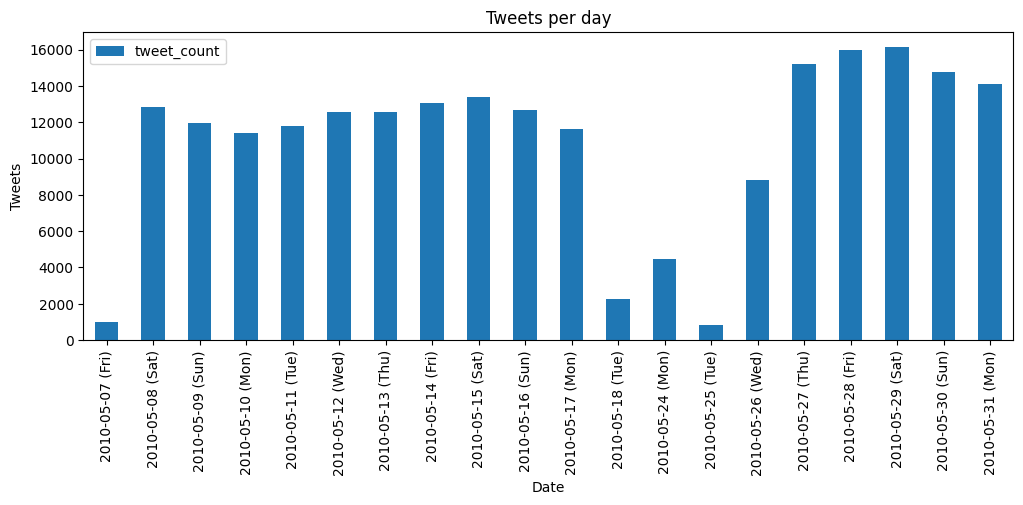

In [9]:
ax = daily_df.plot(kind='bar', x='date', y='tweet_count', figsize=(12,4),
                   title='Tweets per day')
ax.set_xlabel('Date')
ax.set_ylabel('Tweets')
ax.set_xticklabels(
    [f"{d} ({w[:3]})" for d, w in zip(daily_df['date'], daily_df['weekday'])],
    rotation=90
)


## 4) Country distribution (from place.country)

In [10]:

country_counts = Counter()

for tw in iter_tweets(FILES, limit=LIMIT_LINES):
    place = tw.get('place')
    if place and place.get('country'):
        country_counts[place['country']] += 1

country_df = pd.DataFrame(country_counts.most_common(20), columns=['country','tweet_count'])
country_df


,country,tweet_count
0,The United States of America,86273
1,United Kingdom,2668
2,Nederland,2534
3,Canada,2487
4,Deutschland,751
5,France,493
6,España,439
7,Sverige,406
8,Italia,282
9,België,213


## 4b) Global coordinate heatmap

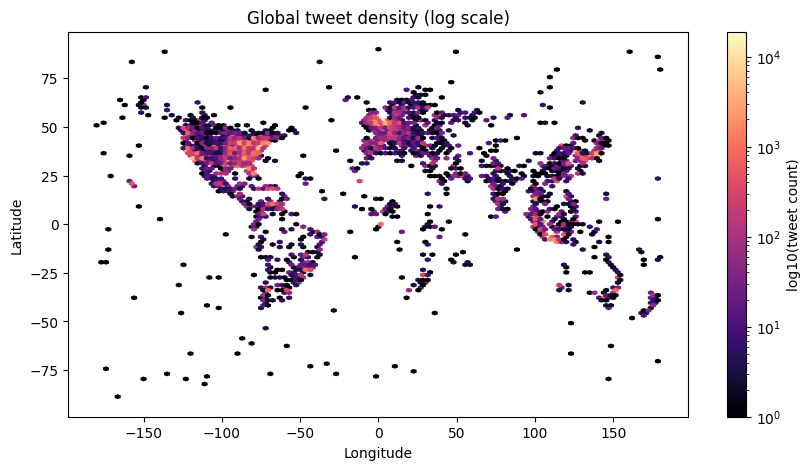

In [12]:

lats = []
lons = []
max_points = 200000  # cap for plotting; adjust as needed

for tw in iter_tweets(FILES, limit=LIMIT_LINES):
    coord = tw.get('coordinates')
    if coord and coord.get('coordinates'):
        lon, lat = coord['coordinates']
        lons.append(lon)
        lats.append(lat)

if len(lats) > max_points:
    idx = np.linspace(0, len(lats)-1, max_points, dtype=int)
    lats = [lats[i] for i in idx]
    lons = [lons[i] for i in idx]

plt.figure(figsize=(10,5))
plt.hexbin(lons, lats, gridsize=120, cmap='magma', bins='log', extent=[-180, 180, -90, 90])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Global tweet density (log scale)')
cb = plt.colorbar()
cb.set_label('log10(tweet count)')
plt.show()


geopandas not available; plotting without map boundaries: The geopandas.dataset has been deprecated and was removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.


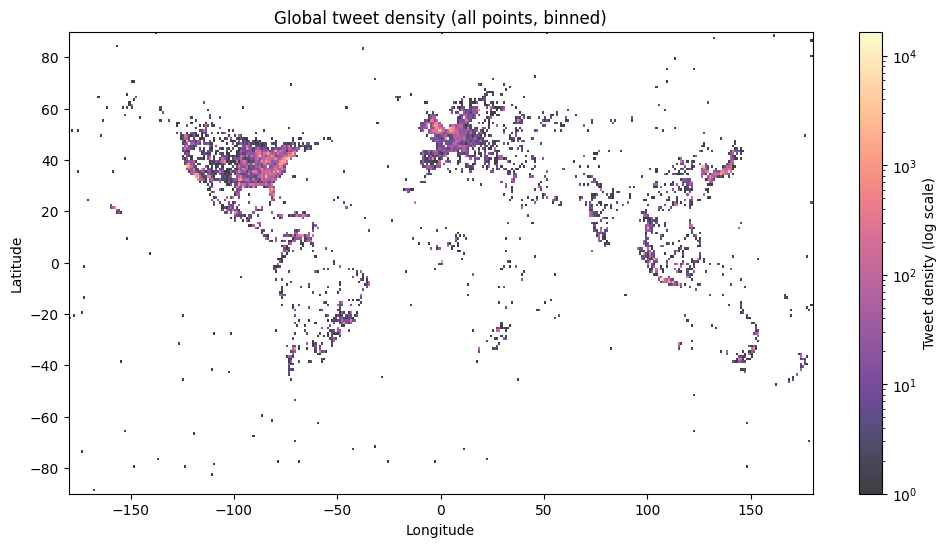

In [13]:
# 4c) Global heatmap over world map (binned, all points)
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

try:
    import geopandas as gpd
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    has_gpd = True
except Exception as exc:
    print('geopandas not available; plotting without map boundaries:', exc)
    has_gpd = False

# Bin size in degrees (adjust for detail vs. speed)
lon_bins = 360  # 1-degree bins
lat_bins = 180  # 1-degree bins

counts = np.zeros((lat_bins, lon_bins), dtype=np.int32)

for tw in iter_tweets(FILES, limit=LIMIT_LINES):
    coord = tw.get('coordinates')
    if coord and coord.get('coordinates'):
        lon, lat = coord['coordinates']
        if -180 <= lon <= 180 and -90 <= lat <= 90:
            x = int((lon + 180) / 360 * lon_bins)
            y = int((lat + 90) / 180 * lat_bins)
            x = min(max(x, 0), lon_bins - 1)
            y = min(max(y, 0), lat_bins - 1)
            counts[y, x] += 1

lon_edges = np.linspace(-180, 180, lon_bins + 1)
lat_edges = np.linspace(-90, 90, lat_bins + 1)

fig, ax = plt.subplots(figsize=(12, 6))
if has_gpd:
    world.boundary.plot(ax=ax, linewidth=0.5, color='white')

mesh = ax.pcolormesh(
    lon_edges,
    lat_edges,
    counts,
    cmap='magma',
    norm=LogNorm(vmin=1, vmax=max(1, counts.max())),
    alpha=0.75,
    shading='auto',
)
fig.colorbar(mesh, ax=ax, label='Tweet density (log scale)')
ax.set_xlim(-180, 180)
ax.set_ylim(-90, 90)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Global tweet density (all points, binned)')
plt.show()


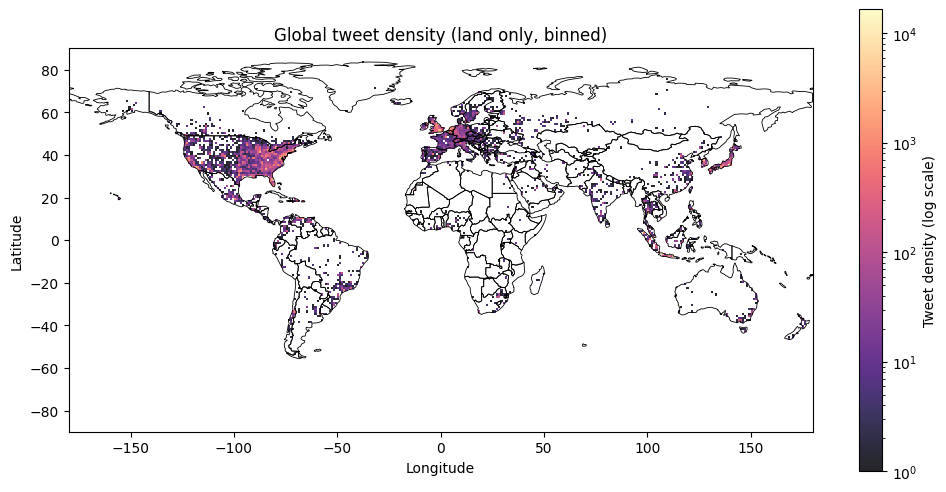

In [14]:
import io
import zipfile
from pathlib import Path
import urllib.request

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from shapely.geometry import Point
from shapely.prepared import prep
import geopandas as gpd

# Download Natural Earth admin-0 countries if missing
DATA_DIR = Path("data/naturalearth")
EXTRACT_DIR = DATA_DIR / "ne_110m_admin_0_countries"
SHP_PATH = EXTRACT_DIR / "ne_110m_admin_0_countries.shp"
URL = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"

if not SHP_PATH.exists():
    EXTRACT_DIR.mkdir(parents=True, exist_ok=True)
    print("Downloading Natural Earth countries...")
    with urllib.request.urlopen(URL) as resp:
        data = resp.read()
    with zipfile.ZipFile(io.BytesIO(data)) as zf:
        zf.extractall(EXTRACT_DIR)

world = gpd.read_file(SHP_PATH)
name_col = "NAME" if "NAME" in world.columns else ("name" if "name" in world.columns else None)
if name_col:
    world = world[world[name_col] != "Antarctica"]

# Use union_all() to avoid deprecation warning
land_geom = prep(world.union_all())

lon_bins = 360  # 1-degree bins
lat_bins = 180
counts = np.zeros((lat_bins, lon_bins), dtype=np.int32)

for tw in iter_tweets(FILES, limit=LIMIT_LINES):
    coord = tw.get("coordinates")
    if not (coord and coord.get("coordinates")):
        continue
    lon, lat = coord["coordinates"]
    if abs(lon) < 1e-6 and abs(lat) < 1e-6:
        continue
    if -180 <= lon <= 180 and -90 <= lat <= 90:
        x = int((lon + 180) / 360 * lon_bins)
        y = int((lat + 90) / 180 * lat_bins)
        x = min(max(x, 0), lon_bins - 1)
        y = min(max(y, 0), lat_bins - 1)
        counts[y, x] += 1

lon_edges = np.linspace(-180, 180, lon_bins + 1)
lat_edges = np.linspace(-90, 90, lat_bins + 1)

# Land-only mask
lon_centers = (lon_edges[:-1] + lon_edges[1:]) / 2
lat_centers = (lat_edges[:-1] + lat_edges[1:]) / 2
mask = np.zeros_like(counts, dtype=bool)
for yi, lat in enumerate(lat_centers):
    for xi, lon in enumerate(lon_centers):
        if land_geom.contains(Point(lon, lat)):
            mask[yi, xi] = True

counts_masked = np.where(mask, counts, 0)

fig, ax = plt.subplots(figsize=(12, 6))

mesh = ax.pcolormesh(
    lon_edges,
    lat_edges,
    counts_masked,
    cmap="magma",
    norm=LogNorm(vmin=1, vmax=max(1, counts_masked.max())),
    alpha=0.85,
    shading="auto",
    zorder=1,
)

# Draw boundaries on top
world.boundary.plot(ax=ax, linewidth=0.6, color="black", zorder=2)

fig.colorbar(mesh, ax=ax, label="Tweet density (log scale)")
ax.set_xlim(-180, 180)
ax.set_ylim(-90, 90)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Global tweet density (land only, binned)")
plt.show()


## 5) Content signals (hashtags, mentions, source, retweet_count)

In [ ]:

hashtags = Counter()
mentions = Counter()
sources = Counter()
retweet_counts = []

for tw in iter_tweets(FILES, limit=LIMIT_LINES):
    h, m = iter_entities(tw)
    hashtags.update(h)
    mentions.update(m)
    src = tw.get('source')
    if src:
        sources[src] += 1
    if 'retweet_count' in tw and isinstance(tw['retweet_count'], int):
        retweet_counts.append(tw['retweet_count'])

hashtag_df = pd.DataFrame(hashtags.most_common(15), columns=['hashtag','count'])
mention_df = pd.DataFrame(mentions.most_common(15), columns=['mention','count'])
source_df = pd.DataFrame(sources.most_common(10), columns=['source','count'])

print('Top hashtags:')
display(hashtag_df)
print('Top mentions:')
display(mention_df)
print('Top sources:')
display(source_df)

if retweet_counts:
    retweet_s = pd.Series(retweet_counts)
    print('Retweet_count summary:')
    display(retweet_s.describe())


Top hashtags:


,hashtag,count
0,jobs,32316
1,job,26987
2,tweetmyjobs,18488
3,jagadtrack,12382
4,ff,9513
5,nowplaying,6577
6,fb,6464
7,oomf,5798
8,np,5647
9,teamfollowback,3970


Top mentions:


,mention,count
0,foursquare,41674
1,imintwt,2838
2,justinbieber,2743
3,xstrology,1340
4,detikcom,963
5,jawabjujur,896
6,tweetramalan,812
7,ladygaga,803
8,rihanna,757
9,drake,698


Top sources:


,source,count
0,"<a href=""http://twitter.com/#!/download/iphone...",2442297
1,"<a href=""http://foursquare.com"" rel=""nofollow""...",902709
2,"<a href=""http://twitter.com/download/android"" ...",868833
3,"<a href=""http://www.tweetcaster.com"" rel=""nofo...",149405
4,"<a href=""http://blackberry.com/twitter"" rel=""n...",148476
5,"<a href=""http://mobile.twitter.com"" rel=""nofol...",143603
6,"<a href=""http://ubersocial.com"" rel=""nofollow""...",120142
7,"<a href=""http://www.twitter.com"" rel=""nofollow...",59070
8,"<a href=""http://www.handmark.com"" rel=""nofollo...",58634
9,"<a href=""http://www.tweetdeck.com"" rel=""nofoll...",57066


Retweet_count summary:


count    5.459773e+06
mean     3.479998e-06
std      2.672666e-03
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      5.000000e+00
dtype: float64